Q1. Analyzing dataset

In [3]:
import numpy as np
import pandas as pd
from collections import Counter

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [4]:
cnt=surv['Survived'].value_counts() 
print("Count of each class")
print(cnt)
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape



Count of each class
GE5    225
L5      81
Name: Survived, dtype: int64


((306, 3), (306,))

In [5]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))


Minority class : 0.26


In [6]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [7]:
model_d = {}

model_d['dtree'] = DecisionTreeClassifier(criterion='entropy')
model_d['kNN'] = KNeighborsClassifier(n_neighbors=3)  
model_d['gb'] =GradientBoostingClassifier()
model_d['logistic'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bias_d = {}
acc_bl = {}
pred_neg={}
test_neg={}
y_pred={}


In [8]:
for m in model_d:
    y_pred[m] = model_d[m].fit(X_train, y_train).predict(X_test)
    pred_neg[m] = Counter(y_pred[m])['L5']
    test_neg[m] = Counter(y_test)['L5']
    print(type(model_d[m]).__name__)
    print("Minority class in test set : %0.2f" % (test_neg[m]))
    print("Predicted minority class : %0.2f" % (pred_neg[m]))
    pred_count=pred_neg[m]/test_neg[m]
    bias_d[m]=pred_count
    
    acc = accuracy_score(y_test, y_pred[m])
    acc_bl[m] = acc
    confusion = confusion_matrix(y_test, y_pred[m])
    print("Confusion Matrix")
    print(confusion)
    print("{:22} Prediction. Minority: {:f} Accuracy: {:.2f} ".format(type(model_d[m]).__name__, pred_count,acc))


DecisionTreeClassifier
Minority class in test set : 31.00
Predicted minority class : 18.00
Confusion Matrix
[[38  8]
 [21 10]]
DecisionTreeClassifier Prediction. Minority: 0.580645 Accuracy: 0.62 
KNeighborsClassifier
Minority class in test set : 31.00
Predicted minority class : 13.00
Confusion Matrix
[[41  5]
 [23  8]]
KNeighborsClassifier   Prediction. Minority: 0.419355 Accuracy: 0.64 
GradientBoostingClassifier
Minority class in test set : 31.00
Predicted minority class : 12.00
Confusion Matrix
[[39  7]
 [26  5]]
GradientBoostingClassifier Prediction. Minority: 0.387097 Accuracy: 0.57 
LogisticRegression
Minority class in test set : 31.00
Predicted minority class : 3.00
Confusion Matrix
[[45  1]
 [29  2]]
LogisticRegression     Prediction. Minority: 0.096774 Accuracy: 0.61 


We can see that very less minority class is actually getting predictied. This is happening because of the dataset is baised towards majority. We can notice that LogisticRegression has the least minority prediction score. See below, graph is used to compare these algorithms.   

In [9]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

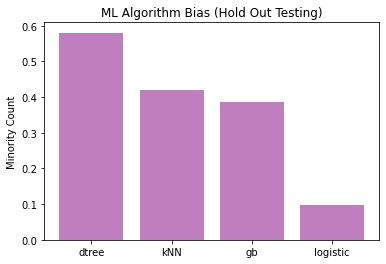

In [10]:
objects = list(bias_d.keys())
positive =list(bias_d.values())

y_pos = np.arange(len(objects))
plt.bar(y_pos, positive, align='center', color=['purple', 'purple','purple','purple'],alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Minority Count')
plt.title('ML Algorithm Bias (Hold Out Testing)')
 
plt.show()

Above is result for Hold Out testing. For cross valisation we can see different more better results. We can see more predictions about minority class is done. As expected, Logistic regression algorithm is giving the least minority prediction socre.

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

def tp(y_test, y_pred): return confusion_matrix(y_test, y_pred)[0,0]
def tn(y_test, y_pred): return confusion_matrix(y_test, y_pred)[1, 1]
def fp(y_test, y_pred): return confusion_matrix(y_test, y_pred)[1, 0]
def fn(y_test, y_pred): return confusion_matrix(y_test, y_pred)[0, 1]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

folds = 4
v = 0

In [12]:
bias_cv = {}

for m in model_d:
    n_tot=0
    cv_results = cross_validate(model_d[m], X, y, cv= folds,scoring=scoring)
    n_tot = cv_results['test_tn'].sum() + cv_results['test_fn'].sum()
    acc = (cv_results['test_tp'].sum() + cv_results['test_tn'].sum())/len(y)
    bias_cv[m] = n_tot
  
    print("{}  Cross Validation {:22} Minority N: {:d} Predicted N: {:d} Acc: {:.2f}".format(folds, type(model_d[m]).__name__, 
                                                                  cnt[0] , n_tot,acc)) 

4  Cross Validation DecisionTreeClassifier Minority N: 225 Predicted N: 115 Acc: 0.60
4  Cross Validation KNeighborsClassifier   Minority N: 225 Predicted N: 114 Acc: 0.60
4  Cross Validation GradientBoostingClassifier Minority N: 225 Predicted N: 140 Acc: 0.53
4  Cross Validation LogisticRegression     Minority N: 225 Predicted N: 25 Acc: 0.75


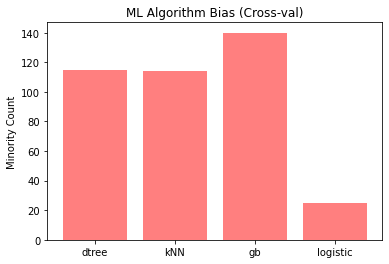

[55 56 51 53]


In [13]:
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline 

objects = list(bias_cv.keys())
positive = list(bias_cv.values())

y_pos = np.arange(len(objects))

plt.bar(y_pos, positive, align='center', color=['red', 'red','red','red','red'],alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Minority Count')
plt.title('ML Algorithm Bias (Cross-val)')
 
plt.show()


print(cv_results['test_tp'])

To reduce the bias, we can use many techniques. I have implemented ADASYN technique. This adds synthetic samples of minority class such that majority class and minority class have similar number of data. Which then reduces the bias.

Q2. Reducing Bias

In [14]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('Resampled dataset after ADASYN shape %s' % Counter(y_ada))

Resampled dataset after ADASYN shape Counter({'L5': 180, 'GE5': 179})


In [15]:
bias_d1 = {}
acc_bl1 = {}
pred_neg1={}
test_neg1={}
y_pred1={}
for m in model_d:
    y_pred1[m] = model_d[m].fit(X_ada, y_ada).predict(X_test)
    pred_neg1[m] = Counter(y_pred1[m])['L5']
    test_neg1[m] = Counter(y_test)['L5']
    print(type(model_d[m]).__name__)
    print("Minority class in test set : %0.2f" % (test_neg1[m]))
    print("Predicted minority class : %0.2f" % (pred_neg1[m]))
    pred_count=pred_neg1[m]/test_neg1[m]
    bias_d1[m]=pred_count
    
    acc1 = accuracy_score(y_test, y_pred1[m])
    acc_bl1[m] = acc1
    confusion = confusion_matrix(y_test, y_pred1[m])
    print("Confusion Matrix")
    print(confusion)
    print("{:22} Pred. Minority: {:f} Accuracy: {:.2f} ".format(type(model_d[m]).__name__, pred_count,acc1))

DecisionTreeClassifier
Minority class in test set : 31.00
Predicted minority class : 28.00
Confusion Matrix
[[31 15]
 [18 13]]
DecisionTreeClassifier Pred. Minority: 0.903226 Accuracy: 0.57 
KNeighborsClassifier
Minority class in test set : 31.00
Predicted minority class : 26.00
Confusion Matrix
[[35 11]
 [16 15]]
KNeighborsClassifier   Pred. Minority: 0.838710 Accuracy: 0.65 
GradientBoostingClassifier
Minority class in test set : 31.00
Predicted minority class : 28.00
Confusion Matrix
[[33 13]
 [16 15]]
GradientBoostingClassifier Pred. Minority: 0.903226 Accuracy: 0.62 
LogisticRegression
Minority class in test set : 31.00
Predicted minority class : 24.00
Confusion Matrix
[[36 10]
 [17 14]]
LogisticRegression     Pred. Minority: 0.774194 Accuracy: 0.65 


We can see that after Oversampling, we observe better results. Bias has been reduced across algorithms. Not much impact is observed on accuracy.

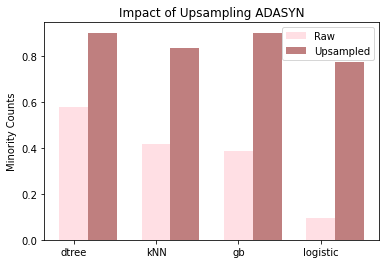

In [16]:
fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects =  list(bias_d.keys())
positive =  list(bias_d.values())
res = list(bias_d1.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=[ 'pink', 'pink','pink','pink'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=[ 'maroon','maroon','maroon','maroon'],alpha=0.5)

ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))

plt.xticks(y_pos, objects)
plt.ylabel('Minority Counts')
plt.title('Impact of Upsampling ADASYN')
 
plt.show()



Plotting the difference between minority class before and after removing bias. We can notice a significant difference especially for Logistic Regression.

Q3. Used diabetes dataset

In [17]:
import numpy as np
import pandas as pd
from collections import Counter
from numpy import unique

from pandas import read_csv

data = pd.read_csv('diabetes.csv')

data.head()

cnt=data['neg_pos'].value_counts() 
print("Count of each class")
print(cnt)
y = data.pop('neg_pos').values
X = data.values
X.shape, y.shape

print("Minority class : %0.2f" % (Counter(y)['tested_positive']/len(y)))


Count of each class
tested_negative    397
tested_positive    198
Name: neg_pos, dtype: int64
Minority class : 0.33


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

model_d = {}

model_d['dtree'] = DecisionTreeClassifier(criterion='entropy')
model_d['kNN'] = KNeighborsClassifier(n_neighbors=3)  
model_d['gb'] =GradientBoostingClassifier()
model_d['logistic'] = LogisticRegression(max_iter=10000, solver = 'sag', random_state=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
bias_d = {}
acc_bl = {}
pred_neg={}
test_neg={}
y_pred={}
for m in model_d:
    y_pred[m] = model_d[m].fit(X_train, y_train).predict(X_test)
    pred_neg[m] = Counter(y_pred[m])['tested_positive']
    test_neg[m] = Counter(y_test)['tested_positive']
    print(type(model_d[m]).__name__)
    print("Minority class in test set : %0.2f" % (test_neg[m]))
    print("Predicted minority class : %0.2f" % (pred_neg[m]))
    pred_count=pred_neg[m]/test_neg[m]
    bias_d[m]=pred_count
    
    acc = accuracy_score(y_test, y_pred[m])
    acc_bl[m] = acc
    confusion = confusion_matrix(y_test, y_pred[m])
    print("Confusion Matrix")
    print(confusion)
    print("{:22} Prediction. Minority: {:f} Accuracy: {:.2f} ".format(type(model_d[m]).__name__, pred_count,acc))


DecisionTreeClassifier
Minority class in test set : 47.00
Predicted minority class : 46.00
Confusion Matrix
[[84 18]
 [19 28]]
DecisionTreeClassifier Prediction. Minority: 0.978723 Accuracy: 0.75 
KNeighborsClassifier
Minority class in test set : 47.00
Predicted minority class : 43.00
Confusion Matrix
[[84 18]
 [22 25]]
KNeighborsClassifier   Prediction. Minority: 0.914894 Accuracy: 0.73 
GradientBoostingClassifier
Minority class in test set : 47.00
Predicted minority class : 44.00
Confusion Matrix
[[88 14]
 [17 30]]
GradientBoostingClassifier Prediction. Minority: 0.936170 Accuracy: 0.79 
LogisticRegression
Minority class in test set : 47.00
Predicted minority class : 29.00
Confusion Matrix
[[88 14]
 [32 15]]
LogisticRegression     Prediction. Minority: 0.617021 Accuracy: 0.69 


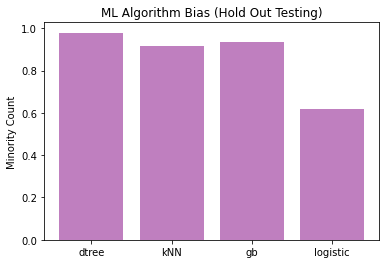

In [19]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline 

# Add the prior figures to the data for plotting
objects = list(bias_d.keys())
positive =list(bias_d.values())

y_pos = np.arange(len(objects))
plt.bar(y_pos, positive, align='center', color=['purple', 'purple','purple','purple'],alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Minority Count')
plt.title('ML Algorithm Bias (Hold Out Testing)')
 
plt.show()



In [20]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('Resampled dataset after ADASYN shape %s' % Counter(y_ada))


bias_d1 = {}
acc_bl1 = {}
pred_neg1={}
test_neg1={}
y_pred1={}
for m in model_d:
    y_pred1[m] = model_d[m].fit(X_ada, y_ada).predict(X_test)
    pred_neg1[m] = Counter(y_pred1[m])['tested_positive']
    test_neg1[m] = Counter(y_test)['tested_positive']

    print("Minority class in test set : %0.2f" % (test_neg1[m]))
    print("Predicted minority class : %0.2f" % (pred_neg1[m]))
    pred_count=pred_neg1[m]/test_neg1[m]
    bias_d1[m]=pred_count
    
    acc1 = accuracy_score(y_test, y_pred1[m])
    acc_bl1[m] = acc1
    confusion = confusion_matrix(y_test, y_pred1[m])
    print("Confusion Matrix")
    print(confusion)
    print("{:22} Pred. Minority: {:f} Accuracy: {:.2f} ".format(type(model_d[m]).__name__, pred_count,acc1))

Resampled dataset after ADASYN shape Counter({'tested_negative': 295, 'tested_positive': 280})
Minority class in test set : 47.00
Predicted minority class : 65.00
Confusion Matrix
[[69 33]
 [15 32]]
DecisionTreeClassifier Pred. Minority: 1.382979 Accuracy: 0.68 
Minority class in test set : 47.00
Predicted minority class : 69.00
Confusion Matrix
[[65 37]
 [15 32]]
KNeighborsClassifier   Pred. Minority: 1.468085 Accuracy: 0.65 
Minority class in test set : 47.00
Predicted minority class : 59.00
Confusion Matrix
[[79 23]
 [11 36]]
GradientBoostingClassifier Pred. Minority: 1.255319 Accuracy: 0.77 
Minority class in test set : 47.00
Predicted minority class : 73.00
Confusion Matrix
[[65 37]
 [11 36]]
LogisticRegression     Pred. Minority: 1.553191 Accuracy: 0.68 


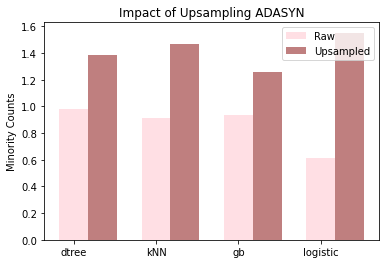

In [21]:
import matplotlib.pyplot as plt 
import numpy as np
#%matplotlib inline 

fig, ax = plt.subplots()
width = 0.35

# Add the prior figures to the data for plotting
objects =  list(bias_d.keys())
positive =  list(bias_d.values())
res = list(bias_d1.values())

y_pos = np.arange(len(objects))

p1 = ax.bar(y_pos, positive, width, align='center', 
            color=[ 'pink', 'pink','pink','pink'],alpha=0.5)

p2 = ax.bar(y_pos+width, res, width, align='center', 
            color=[ 'maroon','maroon','maroon','maroon'],alpha=0.5)

ax.legend((p1[1], p2[1]), ('Raw', 'Upsampled'))

plt.xticks(y_pos, objects)
plt.ylabel('Minority Counts')
plt.title('Impact of Upsampling ADASYN')
 
plt.show()


We can obsevre that after performing ADASYN, the results are actually getting biased towards the minority class. This is one of the drawbacks of oversampling. Because the data set was not very biased, after oversampling it got reverse-biased towards the minority class. This did not happen in case of Q1 and Q2 because the data set in those questions had very vast difference between 2 class count. i.e there were very few data entries for minority class. 